# Looking for the subsurface chlorophyll A maximum in a global fluorescence chlorophyll profile dataset


## characterizing the SO (A5, I5, P5) and North-Polar (Arctic/A1/P1) subsurface chloropyll maxima

The data is a synthesis product that comes from here:
https://www.seanoe.org/data/00311/42182/

{BGC Sprof data files (2022-10-08 snapshot)}


In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

### establish regions and import mask

Text(0.5, 0.98, 'check that norm of colours works')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


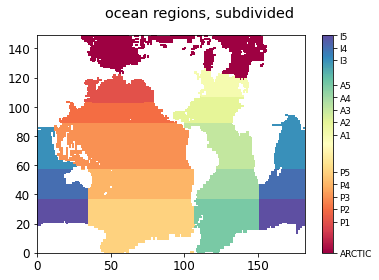

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


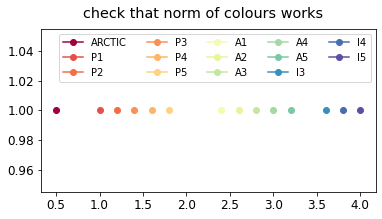

In [4]:
regs = ['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

regdict = {'ARCTIC' : {'number' : 0.5},
           'P1' : {'number': 1.0},
          'P2' : {'number': 1.2},
           'P3' : {'number': 1.4},
           'P4' : {'number': 1.6},
           'P5' : {'number': 1.8},
            'A1' : {'number': 2.4},
          'A2' : {'number': 2.6},
           'A3' : {'number': 2.8},
           'A4' : {'number': 3},
           'A5' : {'number': 3.2},
           'I3' : {'number': 3.6},
           'I4' : {'number': 3.8},
           'I5' : {'number': 4},
           
          }
    
tics = []
tcm = 'Spectral'
tmask = nc.Dataset('/gpfs/data/greenocean/software/resources/breakdown/clq_basin_masks_ORCA.nc')

maskno = np.zeros([149,182])
for i in range(0, len(regs)):
    maskno[tmask[regs[i]][:] == 1] = regdict[regs[i]]['number']
    tics.append(regdict[regs[i]]['number'])
maskno[maskno == 0] = np.nan

w = plt.pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
cbar = plt.colorbar(w, ticks=tics)
t = cbar.ax.set_yticklabels(['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5'], fontsize = 9)
plt.suptitle('ocean regions, subdivided')

fact = 0.2
fig = plt.figure(figsize=(30*fact,15*fact))
import matplotlib
cmap = matplotlib.cm.get_cmap('Spectral')
norm = matplotlib.colors.Normalize(vmin=0.5, vmax=4)
for i in range(0,len(regs)):
    rgba = cmap(norm(regdict[regs[i]]['number']))
    plt.plot(regdict[regs[i]]['number'], 1, marker = 'o', color = rgba, label = regs[i])
    regdict[regs[i]]['colour'] = rgba
plt.legend(ncol = 5, fontsize = 10)
plt.suptitle('check that norm of colours works')

## primary extraction process description

    - set horse flag to True in cell below to run (horses run)
    - Load individual BGC argo profiles and check if they contain chlA
    - for each profile, get out CHLA_ADJUSTED and CHLA_ADJUSTED_QC
    - look only at CHLA_ADJUSTED where CHLA_ADJUSTED_QC is 1
    - find depth of subsurface chl max, store depth and identity of max
    - also check whether the depth of the SS chlmax is identical to the first measurement (for possibility of discarding later)
    - save table with these data as csv, then concatenate csv on identity of profile (which is float number concatenated with prof. number / 1000)

In [5]:
horse = False

In [6]:
sset = ['coriolis','kma','csiro','bodc', 'nmdis', 'incois', 'aoml', 'meds', 'csio', 'kordi', 'jma']

In [7]:
if horse:
    i = 0
    with_chl = []
    for i in range(0,len(sset)):
        w = glob.glob(f'/gpfs/data/greenocean/observations/202210-BgcArgoSprof/dac/{sset[i]}/*.nc')
        print(len(w))
        for r in range(0,len(w)):
            tw = xr.open_dataset(w[r])
            if 'CHLA' in tw.keys():
                with_chl.append(w[r])
    pickle.dump(with_chl, open("./pkls/BGCwithCHL.pkl", 'wb'))


In [8]:
verbose = False
if horse:

    BGClist = pickle.load(open('./pkls/BGCwithCHL.pkl', 'rb'))

    for i in range(0,len(BGClist)):
        t1 = time.time()
        print(f'{i}: extracting subsurface chlorophyll for {BGClist[i]}')
        w = xr.open_dataset(BGClist[i])
        #print(w)
        tplat = (np.unique(w['PLATFORM_NUMBER']).astype(float))
        tplat = int(tplat[0])
        testnam = f'CHLMAX_{w.institution}_{tplat}.csv'
        print(f'to {testnam}')
        no_profs = (len(w['N_PROF']))

        funct_prof = []
        for k in range(0,no_profs):

            testchl_qc = w['CHLA_ADJUSTED_QC'][k,:].values.astype(float)
            tmin = np.nanmin(testchl_qc)
            if tmin <= 1.0:
                funct_prof.append(k)


        ## save lat, lon, y, x, region of ocean, date, loc of max
        floatno = np.zeros(len(funct_prof))
        lat = np.zeros(len(funct_prof))
        lon = np.zeros(len(funct_prof))
        mon = np.zeros(len(funct_prof))
        day = np.zeros(len(funct_prof))    
        year = np.zeros(len(funct_prof))
        chlmax = np.zeros(len(funct_prof))
        chlmean = np.zeros(len(funct_prof))
        depth_chlmax= np.zeros(len(funct_prof))
        max_below_first_measurement = np.zeros(len(funct_prof))
        max_double_mean = np.zeros(len(funct_prof))
        Y = np.zeros(len(funct_prof))
        X = np.zeros(len(funct_prof))
        
        for k in range(0,len(funct_prof)):

            tp = funct_prof[k]

            testchl = w['CHLA_ADJUSTED'][tp,:].values.astype(float)
            testchl_qc = w['CHLA_ADJUSTED_QC'][tp,:].values.astype(float)
            testpres = w['PRES'][tp,:].values.astype(float)
            filt = (testchl_qc == 1.0)

            foran_chl = testchl[filt]
            foran_pres = testpres[filt]

            chlmax[k] = (np.nanmax(foran_chl)) 
            chlmean[k] = (np.nanmean(foran_chl))#max fluorescence 
            dchlmax = ((np.where(foran_chl == chlmax[k]))[0][0])
            depth_chlmax[k] = foran_pres[dchlmax]
            firstmes = (np.nanmin(testpres[filt]))

            if depth_chlmax[k] > firstmes:
                max_below_first_measurement[k] = 1
            if chlmax[k] >= 2* chlmean[k]:
                max_double_mean[k] = 1
            
            #place in spacetime, number of float, number of profiles            
            lat[k] = w['LATITUDE'][tp].values.astype(float)
            lon[k] = w['LONGITUDE'][tp].values.astype(float)
            Y[k], X[k] = ut.find_closest(lon[k], lat[k])
            testjuld = pd.to_datetime(w['JULD'][tp].values)
            mon[k] = testjuld.month
            day[k] = testjuld.day
            year[k] = testjuld.year
            floatno[k] = tplat + tp/1000



            if verbose:
                print(f'{lat[k]},{lon[k]},{mon[k]},{day[k]},{year[k]}, maxchl {chlmax[k]}, loc = {depth_chlmax[k]}, float = {floatno[k]}')
                plt.figure()
                plt.plot(testchl,-testpres)
                plt.plot(chlmax[k],-depth_chlmax[k],'r*')

        df = pd.DataFrame([floatno,lat,lon,X,Y,mon,day,year,chlmax,depth_chlmax,max_below_first_measurement,chlmean,max_double_mean]).T
            # df = df.sort_values(by = tYEAR)
        df.columns = ['profno','lat','lon','X','Y','mon','day','year','chlmax','depth_chlmax','max_below_first_measurement','chlmean','max_double_mean']
        if i == 1:
            print(df.columns)
        df.wheremade = 'evalOutput/BGC_subsurfacechla.ipynb'
        df.to_csv(f'./argo_processed/{testnam}')

        t2 = time.time()        
        print(t2-t1)
        print()


In [9]:
w = pd.read_csv('./argo_processed/CHLMAX_AOML_1902303.csv')
w.columns

Index(['Unnamed: 0', 'profno', 'lat', 'lon', 'X', 'Y', 'mon', 'day', 'year',
       'chlmax', 'depth_chlmax', 'max_below_first_measurement', 'chlmean',
       'max_double_mean'],
      dtype='object')

## short demo of peak finding alg. on several individual profiles

0: extracting subsurface chlorophyll for /gpfs/data/greenocean/observations/202210-BgcArgoSprof/dac/coriolis/6902907_Sprof.nc
to CHLMAX_CORIOLIS_6902907.csv
-7.989143333333333,-140.47197166666666,1.0,31.0,2019.0, maxchl 0.32850000262260437, loc = 83.5999984741211, float = 6902907.109


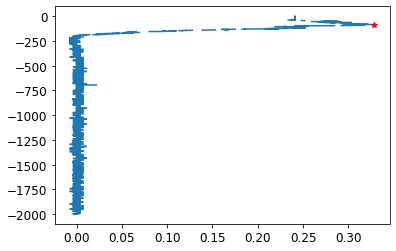

In [10]:
verbose = True


BGClist = pickle.load(open('./pkls/BGCwithCHL.pkl', 'rb'))

for i in range(0,1):#len(BGClist)):
    t1 = time.time()
    print(f'{i}: extracting subsurface chlorophyll for {BGClist[i]}')
    w = xr.open_dataset(BGClist[i])
    #print(w)
    tplat = (np.unique(w['PLATFORM_NUMBER']).astype(float))
    tplat = int(tplat[0])
    testnam = f'CHLMAX_{w.institution}_{tplat}.csv'
    print(f'to {testnam}')
    no_profs = (len(w['N_PROF']))

    funct_prof = []
    for k in range(0,no_profs):

        testchl_qc = w['CHLA_ADJUSTED_QC'][k,:].values.astype(float)
        tmin = np.nanmin(testchl_qc)
        if tmin <= 1.0:
            funct_prof.append(k)


    ## save lat, lon, y, x, region of ocean, date, loc of max
    floatno = np.zeros(len(funct_prof))
    lat = np.zeros(len(funct_prof))
    lon = np.zeros(len(funct_prof))
    mon = np.zeros(len(funct_prof))
    day = np.zeros(len(funct_prof))    
    year = np.zeros(len(funct_prof))
    Y = np.zeros(len(funct_prof))
    X = np.zeros(len(funct_prof))
    chlmax = np.zeros(len(funct_prof))
    depth_chlmax= np.zeros(len(funct_prof))
    max_below_first_measurement = np.zeros(len(funct_prof))

    for k in range(0,1):#len(funct_prof)):

        tp = funct_prof[k]

        testchl = w['CHLA_ADJUSTED'][tp,:].values.astype(float)
        testchl_qc = w['CHLA_ADJUSTED_QC'][tp,:].values.astype(float)
        testpres = w['PRES'][tp,:].values.astype(float)
        filt = (testchl_qc == 1.0)

        foran_chl = testchl[filt]
        foran_pres = testpres[filt]

        chlmax[k] = (np.nanmax(foran_chl)) #max fluorescence 
        dchlmax = ((np.where(foran_chl == chlmax[k]))[0][0])
        depth_chlmax[k] = foran_pres[dchlmax]
        firstmes = (np.nanmin(testpres[filt]))

        if depth_chlmax[k] > firstmes:
            max_below_first_measurement[k] = 1

        #place in spacetime, number of float, number of profiles            
        lat[k] = w['LATITUDE'][tp].values.astype(float)
        lon[k] = w['LONGITUDE'][tp].values.astype(float)
        Y[k], X[k] = ut.find_closest(lon[k], lat[k])
        testjuld = pd.to_datetime(w['JULD'][tp].values)
        mon[k] = testjuld.month
        day[k] = testjuld.day
        year[k] = testjuld.year
        floatno[k] = tplat + tp/1000



        if verbose:
            print(f'{lat[k]},{lon[k]},{mon[k]},{day[k]},{year[k]}, maxchl {chlmax[k]}, loc = {depth_chlmax[k]}, float = {floatno[k]}')
            plt.figure()
            plt.plot(testchl,-testpres)
            plt.plot(chlmax[k],-depth_chlmax[k],'r*')




- concatenate chlorophyll profiles into a single file, called ./argo_processed/concat_chlmax.csv
- find model y, x in findYX_forchlx.py
- concatenate Y,X with the rest of the dataframe, get regions as seen above, save whole thing again

In [11]:
## concatenate chlorophylls 
if horse:
    w = glob.glob('./argo_processed/CHLMAX_*')
    df1 = pd.read_csv(w[0])
    df2 = pd.read_csv(w[1])

    # print(df1)
    # print(df2)
    dfs = []
    # df = pd.concat([df1, df2])
    for i in range(0,len(w)):
        dfs.append(pd.read_csv(w[i]))

    masterdf = pd.concat(dfs)
    masterdf.to_csv(f'./argo_processed/concat_chlmax.csv')

In [12]:
horse2 = False
if horse2:
    masterdf = pd.read_csv('./argo_processed/concat_chlmax.csv')
    masterdf.columns
    Y = np.array(masterdf['Y'])
    X = np.array(masterdf['X'])
#     yx1 = pd.read_csv(f'./argo_processed/chl_yx_0_30000.csv')
#     yx2 = pd.read_csv(f'./argo_processed/chl_yx_30000_end.csv')

#     Y = np.zeros_like(lat)
#     X = np.zeros_like(lat)

#     Y[0:30000] = yx1['Y'][0:30000]
#     X[0:30000] = yx1['X'][0:30000]
#     Y[30000:68000] = yx2['Y'][30000:68000]
#     X[30000:68000] = yx2['X'][30000:68000]

#     masterdf['Y'] = Y
#     masterdf['X'] = X
    tREG = np.zeros_like(Y)

    for i in range(0,len(X)):
        tREG[i] = maskno[int(Y[i]), int(X[i])]
    masterdf['REG'] = tREG        
    masterdf.to_csv(f'./argo_processed/concat_chlmax.csv')

# cleaned dataset look

In [13]:
chlmax = pd.read_csv(f'./argo_processed/concat_chlmax.csv')
chlmax.columns
#chlmax.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'], axis = 1)


Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'profno', 'lat', 'lon',
       'X', 'Y', 'mon', 'day', 'year', 'chlmax', 'depth_chlmax',
       'max_below_first_measurement', 'chlmean', 'max_double_mean', 'REG'],
      dtype='object')

In [14]:
def custhist(tdat, nbins, start, end, tweights = None):
    #bins = 25
    hist_met_vflx, bins = np.histogram(np.ravel(tdat), bins=nbins,\
                                 range = [start, end], weights=tweights)

    bin_cent = bins + (bins[1]-bins[0])/2
    tot_count = np.sum(hist_met_vflx)

    
    binsback = bins
    bin_cent = bin_cent[0:nbins]
    histback = hist_met_vflx/tot_count
    
    return binsback, bin_cent, histback

- subdivide pandas dataset and check number of obs. (turn on bear flag to run)

In [15]:
bear = False
if bear:
    true_subsurface = ((chlmax['max_below_first_measurement'] == 1.0) & (chlmax['depth_chlmax'] < 5))
    chlmax['depth_chlmax']

    winter_chl = (chlmax.loc[true_subsurface,['depth_chlmax']])
    display(winter_chl)
    winter_chl = (chlmax.loc[true_subsurface])
    display(winter_chl)

    chlmin_threshold = (chlmax['chlmax'] > 0.5)
    true_subsurface = (chlmax['max_below_first_measurement'] == 1.0)
    djf = ((chlmax['mon']>=12) | (chlmax['mon']<=2))
    mam = ((chlmax['mon']>=3) & (chlmax['mon']<=5))
    jja = ((chlmax['mon']>=6) & (chlmax['mon']<=8))
    son = ((chlmax['mon']>=9) & (chlmax['mon']<=11))

    for r in range(0,len(regs)):
        regnum = regdict[regs[r]]['number']
        print(f'{regs[r]},{regnum}')
        regcond = (chlmax['REG'] == regnum)
        djf_chl = (chlmax.loc[(djf &  regcond & true_subsurface & chlmin_threshold),['depth_chlmax']])
        mam_chl = (chlmax.loc[(mam & regcond  & true_subsurface & chlmin_threshold),['depth_chlmax']])
        jja_chl = (chlmax.loc[(jja & regcond & true_subsurface & chlmin_threshold),['depth_chlmax']])
        son_chl = (chlmax.loc[(son & regcond & true_subsurface & chlmin_threshold),['depth_chlmax']])
        print(djf_chl['depth_chlmax'].size)
        print(mam_chl['depth_chlmax'].size)
        print(jja_chl['depth_chlmax'].size)
        print(son_chl['depth_chlmax'].size)

        print()

Text(0.5, 0.96, 'histograms of depth of subsurface chl. max (m), with threshold for detectable chl max considered 1 mg/m3 \n min number of obs to calculate histogram = 10, no. obs shown in legend')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


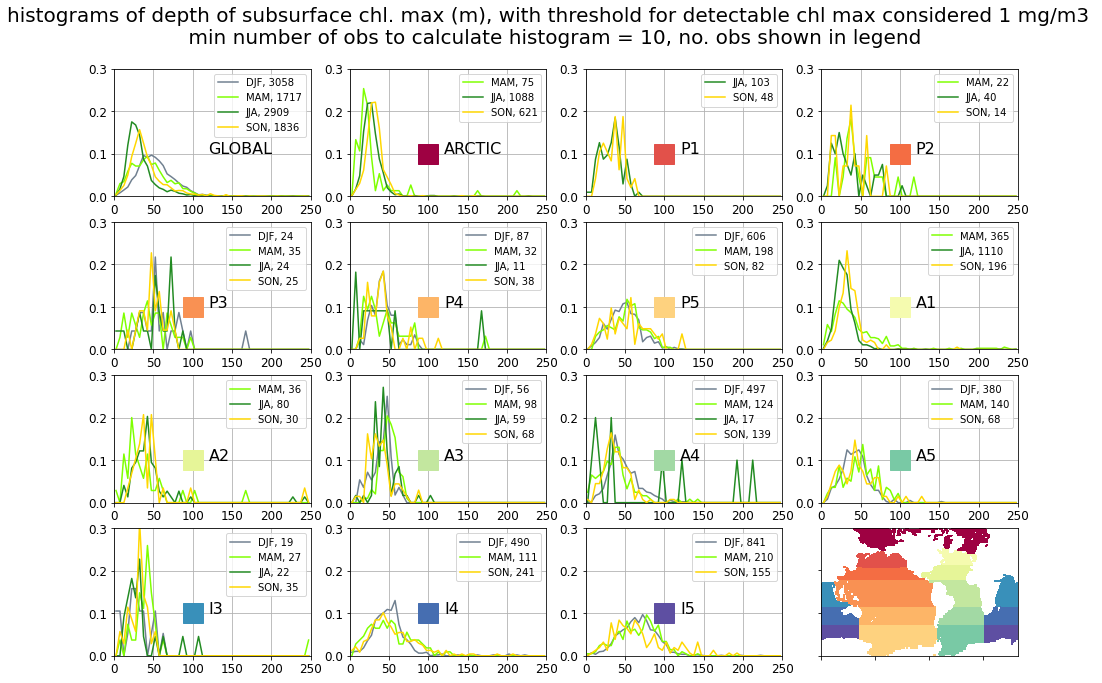

In [16]:
tmax = 1
stit = f'histograms of depth of subsurface chl. max (m), with threshold for detectable chl max considered {tmax} mg/m3 \n min number of obs to calculate histogram = 10, no. obs shown in legend'

fact = 0.9
seasons = ['DJF', 'MAM', 'JJA', 'SON']
seascol = ['slategrey', 'chartreuse', 'forestgreen', 'gold']
fig, axs = plt.subplots(4,4, figsize=(18*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

nbins = 50
start = 0
end = 250

chlmin_threshold = (chlmax['chlmax'] > tmax)
true_subsurface = (chlmax['max_below_first_measurement'] == 1.0)
djf = ((chlmax['mon']>=12) | (chlmax['mon']<=2))
mam = ((chlmax['mon']>=3) & (chlmax['mon']<=5))
jja = ((chlmax['mon']>=6) & (chlmax['mon']<=8))
son = ((chlmax['mon']>=9) & (chlmax['mon']<=11))


djf_chl = (chlmax.loc[(djf & true_subsurface & chlmin_threshold),['depth_chlmax']])
mam_chl = (chlmax.loc[(mam   & true_subsurface & chlmin_threshold),['depth_chlmax']])
jja_chl = (chlmax.loc[(jja  & true_subsurface & chlmin_threshold),['depth_chlmax']])
son_chl = (chlmax.loc[(son  & true_subsurface & chlmin_threshold),['depth_chlmax']])

seaschl = [djf_chl,mam_chl, jja_chl, son_chl]
for s in range(0,4):
    tseas = seaschl[s]
    if tseas['depth_chlmax'].size > 10:
        nsback, bin_cent, histback = custhist(tseas['depth_chlmax'], nbins, start, end)
        tsize = tseas['depth_chlmax'].size
        axs[0].plot(bin_cent,histback, color = seascol[s], label = f'{seasons[s]}, {tsize}')
axs[0].legend(loc = 'best', fontsize = 10)
axs[0].text(120,0.1,'GLOBAL', color = 'k', fontsize = 16)

for r in range(0,len(regs)):
    regnum = regdict[regs[r]]['number']
    #print(f'{regs[r]},{regnum}')
    regcond = (chlmax['REG'] == regnum)
    djf_chl = (chlmax.loc[(djf &  regcond & true_subsurface & chlmin_threshold),['depth_chlmax']])
    mam_chl = (chlmax.loc[(mam & regcond  & true_subsurface & chlmin_threshold),['depth_chlmax']])
    jja_chl = (chlmax.loc[(jja & regcond & true_subsurface & chlmin_threshold),['depth_chlmax']])
    son_chl = (chlmax.loc[(son & regcond & true_subsurface & chlmin_threshold),['depth_chlmax']])
    
    seaschl = [djf_chl,mam_chl, jja_chl, son_chl]
    for s in range(0,4):
        tseas = seaschl[s]
        if tseas['depth_chlmax'].size > 10:
            nsback, bin_cent, histback = custhist(tseas['depth_chlmax'], nbins, start, end)
            tsize = tseas['depth_chlmax'].size
            axs[r+1].plot(bin_cent,histback, color = seascol[s], label = f'{seasons[s]}, {tsize}')
    axs[r+1].legend(loc = 'best', fontsize = 10)

axs[15].pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
axs[15].set_xticklabels([])
axs[15].set_yticklabels([])

# axs[0].text(2100,-560,'GLOBAL', color = 'k', fontsize = 16)


for i in range(0,len(regs)+1):
    axs[i].set_xlim([0,250])
    axs[i].set_ylim([0,0.3])
    axs[i].grid()
for i in range(0,len(regs)):
    axs[i+1].plot(100,0.1,marker = "s", color = regdict[regs[i]]['colour'], markersize = 20)
    axs[i+1].text(120,0.1,regs[i], color = 'k', fontsize = 16)

plt.suptitle(stit, fontsize = 20, y = 0.96)

#### seasonally-separated histogram view of above, turn on thorse to run

In [17]:
thorse = False
if thorse:

    tmax = 1
    stit = f'histograms of depth of subsurface chl. max (m), with threshold for detectable chl max considered {tmax} mg/m3 \n min number of obs to calculate histogram = 10, no. obs shown in legend'

    fact = 0.9
    seasons = ['DJF', 'MAM', 'JJA', 'SON']
    seascol = ['slategrey', 'chartreuse', 'forestgreen', 'gold']
    fig, axs = plt.subplots(2,2, figsize=(18*fact, 12*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    nbins = 50
    start = 0
    end = 250

    chlmin_threshold = (chlmax['chlmax'] > tmax)
    true_subsurface = (chlmax['max_below_first_measurement'] == 1.0)
    true_max = (chlmax['max_double_mean'] == 1.0)
    djf = ((chlmax['mon']>=12) | (chlmax['mon']<=2))
    mam = ((chlmax['mon']>=3) & (chlmax['mon']<=5))
    jja = ((chlmax['mon']>=6) & (chlmax['mon']<=8))
    son = ((chlmax['mon']>=9) & (chlmax['mon']<=11))

    for r in range(0,len(regs)):
        regnum = regdict[regs[r]]['number']
        #print(f'{regs[r]},{regnum}')
        regcond = (chlmax['REG'] == regnum)
        djf_chl = (chlmax.loc[(djf &  regcond & true_subsurface & chlmin_threshold & true_max),['depth_chlmax']])
        mam_chl = (chlmax.loc[(mam & regcond  & true_subsurface & chlmin_threshold & true_max),['depth_chlmax']])
        jja_chl = (chlmax.loc[(jja & regcond & true_subsurface & chlmin_threshold & true_max),['depth_chlmax']])
        son_chl = (chlmax.loc[(son & regcond & true_subsurface & chlmin_threshold & true_max),['depth_chlmax']])

        seaschl = [djf_chl,mam_chl, jja_chl, son_chl]
        for s in range(0,4):
            tseas = seaschl[s]
            if tseas['depth_chlmax'].size > 10:
                nsback, bin_cent, histback = custhist(tseas['depth_chlmax'], nbins, start, end)
                tsize = tseas['depth_chlmax'].size
                axs[s].plot(bin_cent,histback, color = regdict[regs[r]]['colour'], label = f'{regs[r]}, {tsize} obs.')

    for i in range(0,4):
        axs[i].set_xlim([0,250])
        axs[i].set_ylim([0,0.3])
        axs[i].grid()
        axs[i].set_title(seasons[i])
        axs[i].legend(loc = 'best', fontsize = 10)

    plt.suptitle(stit, fontsize = 20, y = 0.96)

In [18]:
showhorse = False; 
if showhorse:
    tdepth = np.array(chlmax['depth_chlmax'])
    tchl = np.array(chlmax['chlmax'])

    fact = 0.4
    fig, axs = plt.subplots(2,2, figsize=(18*fact, 18*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(tchl,-tdepth,'r.', alpha = 0.1)
    # axs[0].set_ylim([-2000,0])
    # axs[0].set_xlim([0,20])
    axs[0].grid()
    axs[0].set_xlabel('chlA mg/m3')
    axs[0].set_ylabel('depth')
    axs[0].set_title('depth and value of chl max \n (all chlorophyll profiles)')

    axs[1].plot(tchl,-tdepth,'r.', alpha = 0.1)
    axs[1].set_ylim([-400,0])
    axs[1].set_xlim([0,20])
    axs[1].grid()
    axs[1].set_xlabel('chlA mg/m3')
    axs[1].set_ylabel('depth')
    axs[1].set_title('depth and value of chl max \n (more reasonable boundaries)')

    axs[2].hist(tdepth, bins = 50); axs[2].set_title('distribution of depths of chl max')
    axs[3].hist(tchl, bins = 50); axs[3].set_title('distribution of values of chl max')
    plt.tight_layout()

## Quick statistics of dataset

#### filters: 

- true subsurface (ie the maximum of the depth profile is below first valid measurement)
- true maximum (ie the maximum of the depth profile is >= 2* the mean)


54978


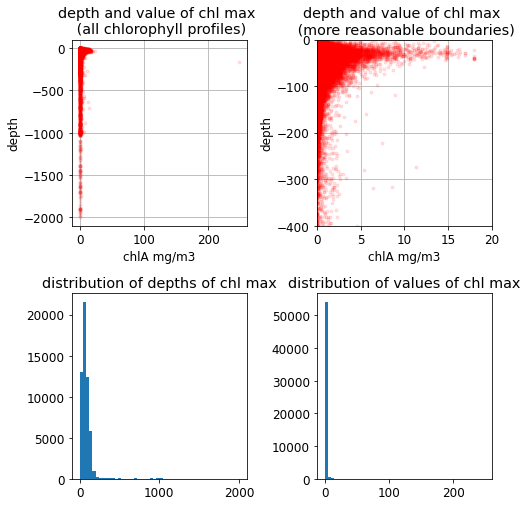

In [20]:
# for r in range(0,len(regs)):
#     regnum = regdict[regs[r]]['number']
#     #print(f'{regs[r]},{regnum}')
#     regcond = (chlmax['REG'] == regnum)
#     djf_chl = (chlmax.loc[(djf &  regcond & true_subsurface & chlmin_threshold & true_max),['depth_chlmax']])
#     mam_chl = (chlmax.loc[(mam & regcond  & true_subsurface & chlmin_threshold & true_max),['depth_chlmax']])
#     jja_chl = (chlmax.loc[(jja & regcond & true_subsurface & chlmin_threshold & true_max),['depth_chlmax']])
#     son_chl = (chlmax.loc[(son & regcond & true_subsurface & chlmin_threshold & true_max),['depth_chlmax']])
true_max = (chlmax['max_double_mean'] == 1.0)    
depth_ssm = (chlmax.loc[(true_subsurface & true_max),['depth_chlmax']])
chl_ssm = (chlmax.loc[(true_subsurface & true_max),['chlmax']])
print(len(chl_ssm))
fact = 0.4
fig, axs = plt.subplots(2,2, figsize=(18*fact, 18*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
axs[0].plot(chl_ssm,-depth_ssm,'r.', alpha = 0.1)
# axs[0].set_ylim([-2000,0])
# axs[0].set_xlim([0,20])
axs[0].grid()
axs[0].set_xlabel('chlA mg/m3')
axs[0].set_ylabel('depth')
axs[0].set_title('depth and value of chl max \n (all chlorophyll profiles)')

axs[1].plot(chl_ssm,-depth_ssm,'r.', alpha = 0.1)
axs[1].set_ylim([-400,0])
axs[1].set_xlim([0,20])
axs[1].grid()
axs[1].set_xlabel('chlA mg/m3')
axs[1].set_ylabel('depth')
axs[1].set_title('depth and value of chl max \n (more reasonable boundaries)')

axs[2].hist(depth_ssm, bins = 50); axs[2].set_title('distribution of depths of chl max')
axs[3].hist(chl_ssm, bins = 50); axs[3].set_title('distribution of values of chl max')
plt.tight_layout()

In [21]:
for r in range(0,len(regs)):
    regnum = regdict[regs[r]]['number']
    #print(f'{regs[r]},{regnum}')
    regcond = (chlmax['REG'] == regnum)
    djf_chl = (chlmax.loc[(djf &  regcond & true_subsurface & chlmin_threshold),['depth_chlmax']])
    djf_depth = (chlmax.loc[(djf & regcond  & true_subsurface & chlmin_threshold),['chlmax']])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ARCTIC
P1
P2
P3
P4
P5
A1
A2
A3
A4
A5
I3
I4
I5


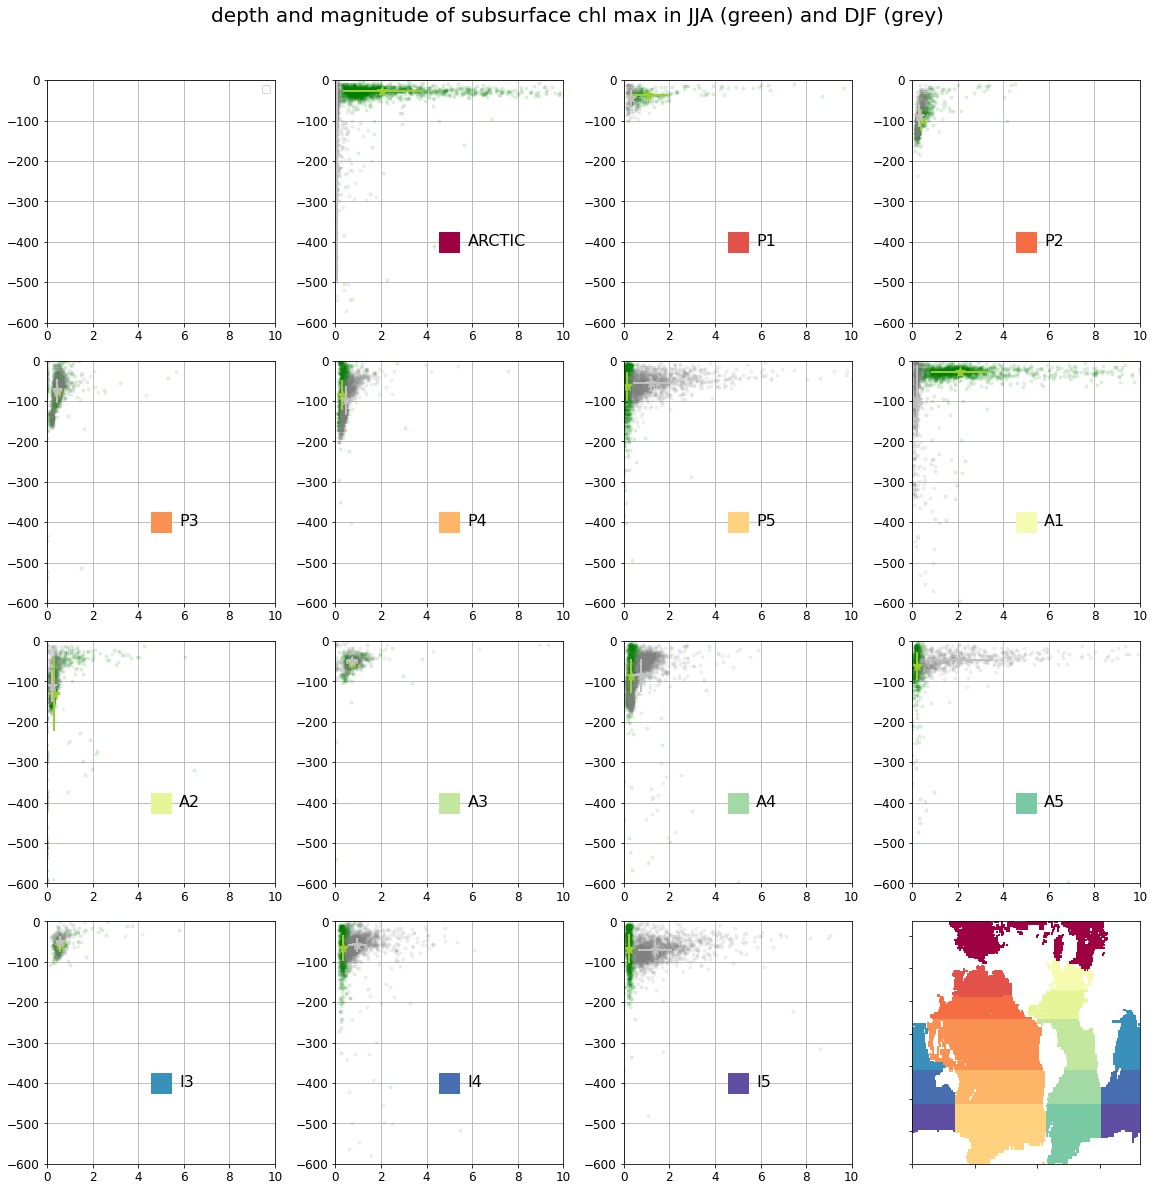

In [22]:
tmax = 1
stit = f'depth and magnitude of subsurface chl max in JJA (green) and DJF (grey)'

fact = 0.9
seasons = ['DJF', 'MAM', 'JJA', 'SON']
seascol = ['slategrey', 'chartreuse', 'forestgreen', 'gold']
fig, axs = plt.subplots(4,4, figsize=(18*fact, 18*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

nbins = 50
start = 0
end = 250

chlmin_threshold = (chlmax['chlmax'] > tmax)
true_subsurface = (chlmax['max_below_first_measurement'] == 1.0)
djf = ((chlmax['mon']>=12) | (chlmax['mon']<=2))
mam = ((chlmax['mon']>=3) & (chlmax['mon']<=5))
jja = ((chlmax['mon']>=6) & (chlmax['mon']<=8))
son = ((chlmax['mon']>=9) & (chlmax['mon']<=11))


# djf_chl = (chlmax.loc[(djf & true_subsurface & chlmin_threshold),['depth_chlmax']])
# mam_chl = (chlmax.loc[(mam   & true_subsurface & chlmin_threshold),['depth_chlmax']])
# jja_chl = (chlmax.loc[(jja  & true_subsurface & chlmin_threshold),['depth_chlmax']])
# son_chl = (chlmax.loc[(son  & true_subsurface & chlmin_threshold),['depth_chlmax']])

# seaschl = [djf_chl,mam_chl, jja_chl, son_chl]
# for s in range(0,4):
#     tseas = seaschl[s]
#     if tseas['depth_chlmax'].size > 10:
#         nsback, bin_cent, histback = custhist(tseas['depth_chlmax'], nbins, start, end)
#         tsize = tseas['depth_chlmax'].size
#         axs[0].plot(bin_cent,histback, color = seascol[s], label = f'{seasons[s]}, {tsize}')

axs[0].legend(loc = 'best', fontsize = 10)
#axs[0].text(120,0.1,'GLOBAL', color = 'k', fontsize = 16)
# depth_ssm = (chlmax.loc[(true_subsurface & true_max),['depth_chlmax']])
# chl_ssm = (chlmax.loc[(true_subsurface & true_max),['chlmax']])
for r in range(0,len(regs)):
    regnum = regdict[regs[r]]['number']
    regcond = (chlmax['REG'] == regnum)
    print(regs[r])
    
    jja_chld = (chlmax.loc[(jja & regcond & true_subsurface & true_max),['depth_chlmax']])
    jja_chl = (chlmax.loc[(jja & regcond & true_subsurface & true_max),['chlmax']])
    axs[r+1].plot(jja_chl,-jja_chld, linestyle = '', marker = '.', color = 'green', alpha = 0.1)
    djf_chld = (chlmax.loc[(djf & regcond & true_subsurface & true_max),['depth_chlmax']])
    djf_chl = (chlmax.loc[(djf & regcond & true_subsurface & true_max),['chlmax']])
    axs[r+1].plot(djf_chl,-djf_chld, linestyle = '', marker = '.', color = 'grey', alpha = 0.1)
    
    ### calc percentiles/ percentages
    tma = (np.percentile(jja_chl,95)); tmi = (np.percentile(jja_chl,5))
    jja_chl_t = jja_chl[(jja_chl>= tmi) & (jja_chl <= tma)]
    jja_chlm = (np.nanmean(jja_chl_t)); jja_chlst = (np.nanstd(jja_chl_t))
    tma = (np.percentile(jja_chld,95)); tmi = (np.percentile(jja_chld,5))
    jja_chld_t = jja_chld[(jja_chld>= tmi) & (jja_chld <= tma)]
    jja_chldm = (np.nanmean(jja_chld_t)); jja_chldst = (np.nanstd(jja_chld_t))
    
    axs[r+1].plot(jja_chlm,-jja_chldm, linestyle = '', marker = '*', markersize = 10, color = 'yellowgreen', alpha = 1)
    st = jja_chlm - jja_chlst; en = jja_chlm + jja_chlst
    axs[r+1].hlines(y = -jja_chldm, xmin = st, xmax = en, color = 'yellowgreen', linewidth = 2)
    st = jja_chldm - jja_chldst; en = jja_chldm + jja_chldst
    #print(st); print(en)
    axs[r+1].vlines(x = jja_chlm, ymin = -st, ymax = -en, color = 'yellowgreen', linewidth = 2)
     
    ### do all the things

    tma = (np.percentile(djf_chl,95)); tmi = (np.percentile(djf_chl,5))
    djf_chl_t = djf_chl[(djf_chl>= tmi) & (djf_chl <= tma)]
    djf_chlm = (np.nanmean(djf_chl_t)); djf_chlst = (np.nanstd(djf_chl_t))
    tma = (np.percentile(djf_chld,95)); tmi = (np.percentile(djf_chld,5))
    djf_chld_t = djf_chld[(djf_chld>= tmi) & (djf_chld <= tma)]
    djf_chldm = (np.nanmean(djf_chld_t)); djf_chldst = (np.nanstd(djf_chld_t))
    
    axs[r+1].plot(djf_chlm,-djf_chldm, linestyle = '', marker = '*', markersize = 10, color = 'silver', alpha = 1)
    st = djf_chlm - djf_chlst; en = djf_chlm + djf_chlst
    axs[r+1].hlines(y = -djf_chldm, xmin = st, xmax = en, color = 'silver', linewidth = 2)
    st = djf_chldm - djf_chldst; en = djf_chldm + djf_chldst
    #print(st); print(en)
    axs[r+1].vlines(x = djf_chlm, ymin = -st, ymax = -en, color = 'silver', linewidth = 2)

axs[15].pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
axs[15].set_xticklabels([])
axs[15].set_yticklabels([])

# axs[0].text(2100,-560,'GLOBAL', color = 'k', fontsize = 16)


for i in range(0,len(regs)+1):
    axs[i].set_xlim([0,10])
    axs[i].set_ylim([-600,0.3])
    axs[i].grid()
for i in range(0,len(regs)):
    axs[i+1].plot(5,-400,marker = "s", color = regdict[regs[i]]['colour'], markersize = 20)
    axs[i+1].text(5.8,-410,regs[i], color = 'k', fontsize = 16)

plt.suptitle(stit, fontsize = 20, y = 1.02)
plt.tight_layout()

## 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


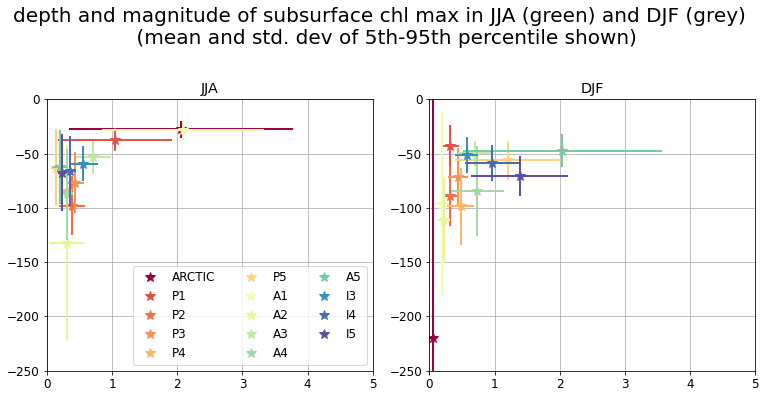

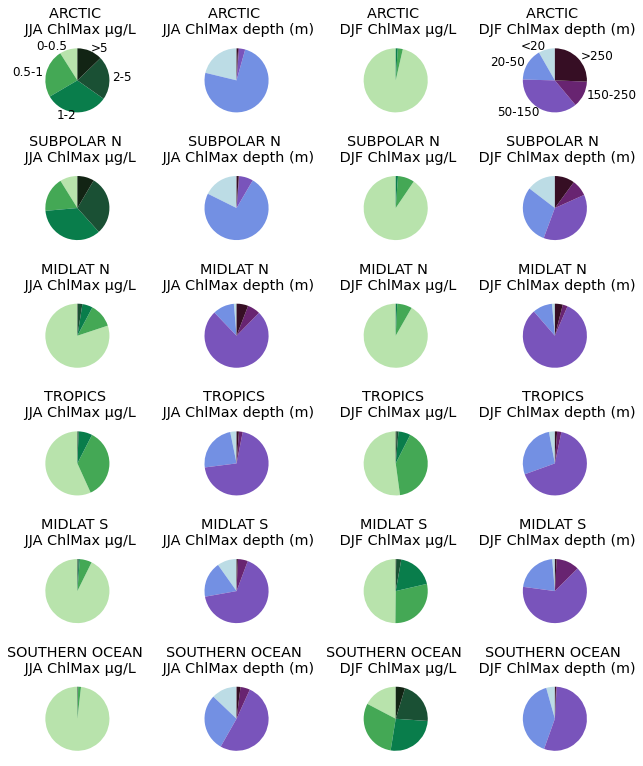

In [132]:
fig, axs = plt.subplots(6,4, figsize=(16*fact, 18*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
tcm = cm.dense
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
regnum = regdict['ARCTIC']['number']
regcond = (chlmax['REG'] ==  regnum)

def make_chl_cond(regcond, seas, axno):
    tcm = cm.algae
    jja_chld = (chlmax.loc[(seas & regcond & true_subsurface & true_max),['depth_chlmax']]).values
    jja_chl = (chlmax.loc[(seas & regcond & true_subsurface & true_max),['chlmax']]).values
    labels = ['0-0.5', '0.5-1', '1-2', '2-5', '>5']
    sizes = [np.size(jja_chl[jja_chl <0.5]), \
             np.size(jja_chl[(jja_chl >=0.5) & (jja_chl < 1)]), \
            np.size(jja_chl[(jja_chl >=1) & (jja_chl < 2)]),\
            np.size(jja_chl[(jja_chl >=2) & (jja_chl < 5)]),\
            np.size(jja_chl[(jja_chl >=5) & (jja_chl < 100)])]
    if axno == 0:
        w = axs[axno].pie(sizes, colors = [tcm(0.5/5),tcm(2/5),tcm(3/5),tcm(4/5),tcm(5/5)],\
                   labels=labels, 
                shadow=False, startangle=90)
    else:
        w = axs[axno].pie(sizes, colors = [tcm(0.5/5),tcm(2/5),tcm(3/5),tcm(4/5),tcm(5/5)],
        shadow=False, startangle=90)
    
def make_chld_cond(regcond, seas, axno):
    tcm = cm.dense
    jja_chld = (chlmax.loc[(seas & regcond & true_subsurface & true_max),['depth_chlmax']]).values
    jja_chl = (chlmax.loc[(seas & regcond & true_subsurface & true_max),['chlmax']]).values
    labels = ['<20', '20-50', '50-150', '150-250', '>250']
    sizes = [np.size(jja_chld[jja_chld <20]), \
             np.size(jja_chld[(jja_chld >=20) & (jja_chld < 50)]), \
            np.size(jja_chld[(jja_chld >=50) & (jja_chld < 150)]),\
            np.size(jja_chld[(jja_chld >=150) & (jja_chld < 250)]),\
            np.size(jja_chld[(jja_chld >=250) & (jja_chld < 10000)])]
    if axno == 3:
        w = axs[axno].pie(sizes, colors = [tcm(0.5/5),tcm(2/5),tcm(3/5),tcm(4/5),tcm(5/5)],\
                   labels=labels, 
                shadow=False, startangle=90)
    else:
        w = axs[axno].pie(sizes, colors = [tcm(0.5/5),tcm(2/5),tcm(3/5),tcm(4/5),tcm(5/5)],
        shadow=False, startangle=90)
    
regnum = regdict['ARCTIC']['number']
regcond = (chlmax['REG'] ==  regnum)
make_chl_cond(regcond, jja, 0)
make_chl_cond(regcond, djf, 2)
make_chld_cond(regcond, jja, 1)
make_chld_cond(regcond, djf, 3)


regnum = regdict['P1']['number']; regnum2 = regdict['A1']['number'] 
regcond = (chlmax['REG'] ==  regnum) | (chlmax['REG'] ==  regnum2)
make_chl_cond(regcond, jja, 0+4)
make_chl_cond(regcond, djf, 2+4)
make_chld_cond(regcond, jja, 1+4)
make_chld_cond(regcond, djf, 3+4)

regnum = regdict['P2']['number']; regnum2 = regdict['A2']['number'] 
regcond = (chlmax['REG'] ==  regnum) | (chlmax['REG'] ==  regnum2)
make_chl_cond(regcond, jja, 0+8)
make_chl_cond(regcond, djf, 2+8)
make_chld_cond(regcond, jja, 1+8)
make_chld_cond(regcond, djf, 3+8)

regnum = regdict['P3']['number']; regnum2 = regdict['A3']['number']; regnum3 = regdict['A3']['number'] 
regcond = (chlmax['REG'] ==  regnum) | (chlmax['REG'] ==  regnum2) | (chlmax['REG'] ==  regnum3)
make_chl_cond(regcond, jja, 0+12)
make_chl_cond(regcond, djf, 2+12)
make_chld_cond(regcond, jja, 1+12)
make_chld_cond(regcond, djf, 3+12)

regnum = regdict['P4']['number']; regnum2 = regdict['A4']['number']; regnum3 = regdict['A4']['number'] 
regcond = (chlmax['REG'] ==  regnum) | (chlmax['REG'] ==  regnum2) | (chlmax['REG'] ==  regnum3)
make_chl_cond(regcond, jja, 0+16)
make_chl_cond(regcond, djf, 2+16)
make_chld_cond(regcond, jja, 1+16)
make_chld_cond(regcond, djf, 3+16)

regnum = regdict['P5']['number']; regnum2 = regdict['A5']['number']; regnum3 = regdict['A5']['number'] 
regcond = (chlmax['REG'] ==  regnum) | (chlmax['REG'] ==  regnum2) | (chlmax['REG'] ==  regnum3)
make_chl_cond(regcond, jja, 0+20)
make_chl_cond(regcond, djf, 2+20)
make_chld_cond(regcond, jja, 1+20)
make_chld_cond(regcond, djf, 3+20)

dregs = ['ARCTIC', 'SUBPOLAR N', 'MIDLAT N', 'TROPICS', 'MIDLAT S', 'SOUTHERN OCEAN']
labs = ['JJA ChlMax µg/L', 'JJA ChlMax depth (m)', 'DJF ChlMax µg/L', 'DJF ChlMax depth (m)']
a = 0 
for j in range(0,6):
    
    for i in range(0,4):
            tit = f'{dregs[j]} \n {labs[i]}'
            axs[a].set_title(tit)
            a = a+1
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


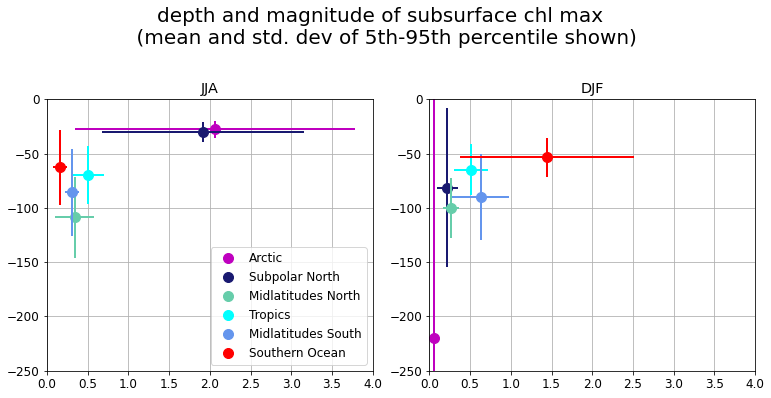

In [151]:
tmax = 1
stit = f'depth and magnitude of subsurface chl max \n (mean and std. dev of 5th-95th percentile shown)'

fact = 0.6
seasons = ['DJF', 'MAM', 'JJA', 'SON']
seascol = ['slategrey', 'chartreuse', 'forestgreen', 'gold']
fig, axs = plt.subplots(1,2, figsize=(18*fact, 9*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

nbins = 50
start = 0
end = 250

chlmin_threshold = (chlmax['chlmax'] > tmax)
true_subsurface = (chlmax['max_below_first_measurement'] == 1.0)
djf = ((chlmax['mon']>=12) | (chlmax['mon']<=2))
mam = ((chlmax['mon']>=3) & (chlmax['mon']<=5))
jja = ((chlmax['mon']>=6) & (chlmax['mon']<=8))
son = ((chlmax['mon']>=9) & (chlmax['mon']<=11))
axs[0].legend(loc = 'best', fontsize = 10)


def plot_centre(regcond, seas, axno, tcol, tlab):
    jja_chld = (chlmax.loc[(seas & regcond & true_subsurface & true_max),['depth_chlmax']]).values
    jja_chl = (chlmax.loc[(seas & regcond & true_subsurface & true_max),['chlmax']]).values
    tma = (np.percentile(jja_chl,95)); tmi = (np.percentile(jja_chl,5))
    jja_chl_t = jja_chl[(jja_chl>= tmi) & (jja_chl <= tma)]
    jja_chlm = (np.nanmean(jja_chl_t)); jja_chlst = (np.nanstd(jja_chl_t))
    tma = (np.percentile(jja_chld,95)); tmi = (np.percentile(jja_chld,5))
    jja_chld_t = jja_chld[(jja_chld>= tmi) & (jja_chld <= tma)]
    jja_chldm = (np.nanmean(jja_chld_t)); jja_chldst = (np.nanstd(jja_chld_t))

    st = jja_chlm - jja_chlst; en = jja_chlm + jja_chlst
    axs[axno].hlines(y = -jja_chldm, xmin = st, xmax = en, \
                  color = tcol, linewidth = 2)
    st = jja_chldm - jja_chldst; en = jja_chldm + jja_chldst
    #print(st); print(en)
    axs[axno].vlines(x = jja_chlm, ymin = -st, ymax = -en, \
                  color = tcol, linewidth = 2)
    axs[axno].plot(jja_chlm,-jja_chldm, linestyle = '', marker = 'o', \
                markersize = 10, color = tcol, alpha = 1, label = tlab)
    
tcol = 'm'; tlab = 'Arctic'
regnum = regdict['ARCTIC']['number']
regcond = (chlmax['REG'] ==  regnum)
plot_centre(regcond, jja, 0, tcol, tlab); plot_centre(regcond, djf, 1, tcol, tlab)

tcol = 'midnightblue'; tlab = 'Subpolar North'
regnum = regdict['P1']['number']; regnum2 = regdict['A1']['number'] 
regcond = (chlmax['REG'] ==  regnum) | (chlmax['REG'] ==  regnum2)
plot_centre(regcond, jja, 0, tcol, tlab); plot_centre(regcond, djf, 1, tcol, tlab)

tcol = 'mediumaquamarine'; tlab = 'Midlatitudes North'
regnum = regdict['P2']['number']; regnum2 = regdict['A2']['number'] 
regcond = (chlmax['REG'] ==  regnum) | (chlmax['REG'] ==  regnum2)
plot_centre(regcond, jja, 0, tcol, tlab); plot_centre(regcond, djf, 1, tcol, tlab)

tcol = 'cyan'; tlab = 'Tropics'
regnum = regdict['P3']['number']; regnum2 = regdict['A3']['number']; regnum3 = regdict['A3']['number'] 
regcond = (chlmax['REG'] ==  regnum) | (chlmax['REG'] ==  regnum2) | (chlmax['REG'] ==  regnum3)
plot_centre(regcond, jja, 0, tcol, tlab); plot_centre(regcond, djf, 1, tcol, tlab)

tcol = 'cornflowerblue'; tlab = 'Midlatitudes South'
regnum = regdict['P4']['number']; regnum2 = regdict['A4']['number']; regnum3 = regdict['A4']['number'] 
regcond = (chlmax['REG'] ==  regnum) | (chlmax['REG'] ==  regnum2) | (chlmax['REG'] ==  regnum3)
plot_centre(regcond, jja, 0, tcol, tlab); plot_centre(regcond, djf, 1, tcol, tlab)

tcol = 'red'; tlab = 'Southern Ocean'
regnum = regdict['P5']['number']; regnum2 = regdict['A5']['number']; regnum3 = regdict['A5']['number'] 
regcond = (chlmax['REG'] ==  regnum) | (chlmax['REG'] ==  regnum2) | (chlmax['REG'] ==  regnum3)
plot_centre(regcond, jja, 0, tcol, tlab); plot_centre(regcond, djf, 1, tcol, tlab)

axs[0].set_title('JJA')
axs[1].set_title('DJF')

axs[0].legend(ncol = 1, loc = 'lower right')
for i in range(0,2):
    axs[i].set_xlim([0,4])
    axs[i].set_ylim([-250,0.3])
    axs[i].grid()
# for i in range(0,len(regs)):
#     axs[i+1].plot(5,-400,marker = "s", color = regdict[regs[i]]['colour'], amarkersize = 20)
#     axs[i+1].text(5.8,-410,regs[i], color = 'k', fontsize = 16)

plt.suptitle(stit, fontsize = 20, y = 1.02)
plt.tight_layout()

In [156]:
## yearlist
def make_yearlist(yrst, yrend, dtype, tr, baseDir):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist



In [203]:
extract = False
if extract:
    yst = 1955; yen = 1960
    dtype =  'diad_T'
    var = 'TChl'
    baseDir = f'/gpfs/afm/greenocean/software/runs/'
    modnams = ['TOM12_RW_3G76','TOM12_RW_3G72', 'TOM12_RW_3G74', \
              'TOM12_RW_3G83', 'TOM12_RW_3G84', 'TOM12_DW_WE43', 'TOM12_DW_GA01', 'TOM12_TJ_1ASA']

    def get_out_chl(modnam, yst, yen):
        print(modnam)
        baseDir = f'/gpfs/afm/greenocean/software/runs/'
        ylist = make_yearlist(yst, yen, 'diad_T', modnam, baseDir) # list of files to open
        tdat = xr.open_mfdataset(ylist) # open file
        tvar = 'TChl' #retreive variable 
        tvar = tdat[var].groupby('time_counter.month').mean('time_counter')
        units = tdat[var].units #retrieve units
        datnam = tdat[var].long_name # retrieve name 

        tnamM = f'./pkls/{modnam}_chlmax_{yst}-{yen}.pkl'
        tnamD = f'./pkls/{modnam}_chlmaxD_{yst}-{yen}.pkl'
        test = tvar[:,:,:,:].values
        print(np.shape(test))

        q = time.time()
        tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
        depths = tmesh['gdept_1d'][0,:]
        maxs = np.zeros([12,149,182])
        chls = np.zeros([12,149,182])
        for m in range(0,12):
            print(m)
            for i in range(0,149):
                for j in range(0,182):
                    tchl = test[m,:,i,j]
                    if np.nanmax(tchl) == 0:
                        maxs[m,i,j] = np.nan
                        chls[m,i,j] = np.nan
                    else:
                        maxs[m,i,j] = depths[(np.where(tchl == np.nanmax(tchl))[0][0])]
                        chls[m,i,j] = np.nanmax(tchl)

        q2 = time.time()
        print(q2-q)
        pickle.dump(maxs, open(tnamM, 'wb'))
        pickle.dump(chls, open(tnamD, 'wb'))


    for v in range(0,len(modnams)):
        modnam = modnams[v]
        get_out_chl(modnam, yst, yen)
    # ylist = make_yearlist(ys, ye, 'grid_T', tr, baseDir) # list of files to open
    # ds = xr.open_mfdataset(ylist) # open file

In [211]:
maskno_broad = np.zeros([12,149,182])

for i in range(0,12):
    maskno_broad[i,:,:] = maskno

In [232]:

#maxs and Ds are backwards, su vul
regcond = (maskno_broad[0:3,:,:] ==  regnum) | (maskno_broad[0:3,:,:] ==  regnum2) | (maskno_broad[0:3,:,:] ==  regnum3)

def plot_summerchl(modnam, yst, yen, regcond, axno, tcol, tlab):
    
    tnamM = f'./pkls/{modnam}_chlmax_{yst}-{yen}.pkl'
    tnamD = f'./pkls/{modnam}_chlmaxD_{yst}-{yen}.pkl'
    tnamD_v = pickle.load(open(tnamM, 'rb'))
    tnamM_v = pickle.load(open(tnamD, 'rb'))

    jja_chld = tnamD_v[5:8,:,:][regcond]
    jja_chl = tnamM_v[5:8,:,:][regcond]

    jja_chld = jja_chld[~np.isnan(jja_chld)]
    jja_chl = jja_chl[~np.isnan(jja_chl)]

    tma = (np.percentile(jja_chl,95)); tmi = (np.percentile(jja_chl,5))
    jja_chl_t = jja_chl[(jja_chl>= tmi) & (jja_chl <= tma)]
    jja_chlm = (np.nanmean(jja_chl_t))*1e6; jja_chlst = (np.nanstd(jja_chl_t))*1e6

    tma = (np.percentile(jja_chld,95)); tmi = (np.percentile(jja_chld,5))
    jja_chld_t = jja_chld[(jja_chld>= tmi) & (jja_chld <= tma)]
    jja_chldm = (np.nanmean(jja_chld_t)); jja_chldst = (np.nanstd(jja_chld_t))

    st = jja_chlm - jja_chlst; en = jja_chlm + jja_chlst
    axs[axno].hlines(y = -jja_chldm, xmin = st, xmax = en, \
                  color = tcol, linewidth = 2)
    st = jja_chldm - jja_chldst; en = jja_chldm + jja_chldst
    #print(st); print(en)
    axs[axno].vlines(x = jja_chlm, ymin = -st, ymax = -en, \
                  color = tcol, linewidth = 2)
    axs[axno].plot(jja_chlm,-jja_chldm, linestyle = '', marker = 'o', \
                markersize = 10, color = tcol, alpha = 1, label = tlab)
    
def plot_djfchl(modnam, yst, yen, regcond, axno, tcol, tlab):
    
    tnamM = f'./pkls/{modnam}_chlmax_{yst}-{yen}.pkl'
    tnamD = f'./pkls/{modnam}_chlmaxD_{yst}-{yen}.pkl'
    tnamD_v = pickle.load(open(tnamM, 'rb'))
    tnamM_v = pickle.load(open(tnamD, 'rb'))

    djf = np.array([0,1,11])
    jja_chld = tnamD_v[djf,:,:][regcond]
    jja_chl = tnamM_v[djf,:,:][regcond]

    jja_chld = jja_chld[~np.isnan(jja_chld)]
    jja_chl = jja_chl[~np.isnan(jja_chl)]

    tma = (np.percentile(jja_chl,95)); tmi = (np.percentile(jja_chl,5))
    jja_chl_t = jja_chl[(jja_chl>= tmi) & (jja_chl <= tma)]
    jja_chlm = (np.nanmean(jja_chl_t))*1e6; jja_chlst = (np.nanstd(jja_chl_t))*1e6

    tma = (np.percentile(jja_chld,95)); tmi = (np.percentile(jja_chld,5))
    jja_chld_t = jja_chld[(jja_chld>= tmi) & (jja_chld <= tma)]
    jja_chldm = (np.nanmean(jja_chld_t)); jja_chldst = (np.nanstd(jja_chld_t))

    st = jja_chlm - jja_chlst; en = jja_chlm + jja_chlst
    axs[axno].hlines(y = -jja_chldm, xmin = st, xmax = en, \
                  color = tcol, linewidth = 2)
    st = jja_chldm - jja_chldst; en = jja_chldm + jja_chldst
    #print(st); print(en)
    axs[axno].vlines(x = jja_chlm, ymin = -st, ymax = -en, \
                  color = tcol, linewidth = 2)
    axs[axno].plot(jja_chlm,-jja_chldm, linestyle = '', marker = 'o', \
                markersize = 10, color = tcol, alpha = 1, label = tlab)


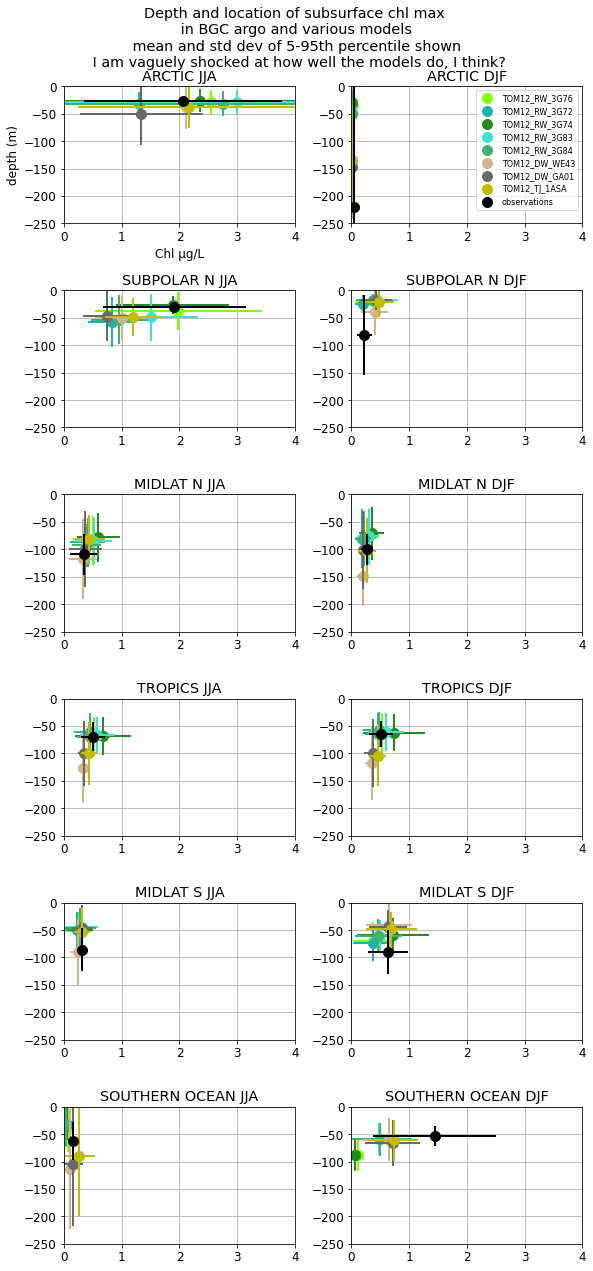

In [252]:
modnams = ['TOM12_RW_3G76','TOM12_RW_3G72', 'TOM12_RW_3G74', \
          'TOM12_RW_3G83', 'TOM12_RW_3G84', 'TOM12_DW_WE43', 'TOM12_DW_GA01', 'TOM12_TJ_1ASA']
cols = ['chartreuse', 'lightseagreen', 'forestgreen', 'turquoise', 'mediumseagreen',\
        'tan','dimgrey','y']
    
fig, axs = plt.subplots(6,2, figsize=(14*fact, 30*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for m in range(0,len(modnams)):
    modnam = modnams[m]; tcol = cols[m]
    regnum = regdict['ARCTIC']['number']
    regcond = (maskno_broad[0:3,:,:] ==  regnum)# | (maskno_broad[0:3,:,:] ==  regnum2) | (maskno_broad[0:3,:,:] ==  regnum3)
    plot_summerchl(modnam, yst, yen, regcond, 0, tcol, modnam)
    plot_djfchl(modnam, yst, yen, regcond, 1, tcol, modnam)
    
    regnum = regdict['P1']['number']; regnum2 = regdict['A1']['number'] 
    regcond = (maskno_broad[0:3,:,:] ==  regnum) | (maskno_broad[0:3,:,:] ==  regnum2) #| (maskno_broad[0:3,:,:] ==  regnum3)
    plot_summerchl(modnam, yst, yen, regcond, 2, tcol, modnam)
    plot_djfchl(modnam, yst, yen, regcond, 3, tcol, modnam)
    
    regnum = regdict['P2']['number']; regnum2 = regdict['A2']['number']
    regcond = (maskno_broad[0:3,:,:] ==  regnum) | (maskno_broad[0:3,:,:] ==  regnum2) #| (maskno_broad[0:3,:,:] ==  regnum3)
    plot_summerchl(modnam, yst, yen, regcond, 4, tcol, modnam)
    plot_djfchl(modnam, yst, yen, regcond, 5, tcol, modnam)
    
    regnum = regdict['P3']['number']; regnum2 = regdict['A3']['number']; regnum3 = regdict['A3']['number'] 
    regcond = (maskno_broad[0:3,:,:] ==  regnum) | (maskno_broad[0:3,:,:] ==  regnum2) | (maskno_broad[0:3,:,:] ==  regnum3)
    plot_summerchl(modnam, yst, yen, regcond, 6, tcol, modnam)
    plot_djfchl(modnam, yst, yen, regcond, 7, tcol, modnam)
    
    regnum = regdict['P4']['number']; regnum2 = regdict['A4']['number']; regnum3 = regdict['A4']['number']
    regcond = (maskno_broad[0:3,:,:] ==  regnum) | (maskno_broad[0:3,:,:] ==  regnum2) | (maskno_broad[0:3,:,:] ==  regnum3)
    plot_summerchl(modnam, yst, yen, regcond, 8, tcol, modnam)
    plot_djfchl(modnam, yst, yen, regcond, 9, tcol, modnam)
    
    regnum = regdict['P5']['number']; regnum2 = regdict['A5']['number']; regnum3 = regdict['A5']['number'] 
    regcond = (maskno_broad[0:3,:,:] ==  regnum) | (maskno_broad[0:3,:,:] ==  regnum2) | (maskno_broad[0:3,:,:] ==  regnum3)
    plot_summerchl(modnam, yst, yen, regcond, 10, tcol, modnam)
    plot_djfchl(modnam, yst, yen, regcond, 11, tcol, modnam)
    
    #plot_centre(regcond, jja, 0, 'k', 'obs'); plot_centre(regcond, djf, 1, 'k', 'obs')
tcol = 'k'; tlab = 'observations'
regnum = regdict['ARCTIC']['number']
regcond = (chlmax['REG'] ==  regnum)
plot_centre(regcond, jja, 0, tcol, tlab); plot_centre(regcond, djf, 1, tcol, tlab)

tcol = 'k'; tlab = 'observations'
regnum = regdict['P1']['number']; regnum2 = regdict['A1']['number'] 
regcond = (chlmax['REG'] ==  regnum) | (chlmax['REG'] ==  regnum2)
plot_centre(regcond, jja, 2, tcol, tlab); plot_centre(regcond, djf, 3, tcol, tlab)

tcol = 'k'; tlab = 'observations'
regnum = regdict['P2']['number']; regnum2 = regdict['A2']['number'] 
regcond = (chlmax['REG'] ==  regnum) | (chlmax['REG'] ==  regnum2)
plot_centre(regcond, jja, 4, tcol, tlab); plot_centre(regcond, djf, 5, tcol, tlab)

tcol = 'k'; tlab = 'observations'
regnum = regdict['P3']['number']; regnum2 = regdict['A3']['number']; regnum3 = regdict['A3']['number'] 
regcond = (chlmax['REG'] ==  regnum) | (chlmax['REG'] ==  regnum2) | (chlmax['REG'] ==  regnum3)
plot_centre(regcond, jja, 6, tcol, tlab); plot_centre(regcond, djf, 7, tcol, tlab)

tcol = 'k'; tlab = 'observations'
regnum = regdict['P4']['number']; regnum2 = regdict['A4']['number']; regnum3 = regdict['A4']['number'] 
regcond = (chlmax['REG'] ==  regnum) | (chlmax['REG'] ==  regnum2) | (chlmax['REG'] ==  regnum3)
plot_centre(regcond, jja, 8, tcol, tlab); plot_centre(regcond, djf, 9, tcol, tlab)

tcol = 'k'; tlab = 'observations'
regnum = regdict['P5']['number']; regnum2 = regdict['A5']['number']; regnum3 = regdict['A5']['number'] 
regcond = (chlmax['REG'] ==  regnum) | (chlmax['REG'] ==  regnum2) | (chlmax['REG'] ==  regnum3)
plot_centre(regcond, jja, 10, tcol, tlab); plot_centre(regcond, djf, 11, tcol, tlab)

axs[1].legend(bbox_to_anchor = [1,1], ncol = 1, fontsize = 8)
for i in range(0,12):
    axs[i].grid()
    axs[i].set_xlim([0,4])
    axs[i].set_ylim([-250,0])
    
dregs = ['ARCTIC', 'SUBPOLAR N', 'MIDLAT N', 'TROPICS', 'MIDLAT S', 'SOUTHERN OCEAN']
labs = ['JJA', 'DJF']
a = 0 
for j in range(0,6):
    
    for i in range(0,2):
            tit = f'{dregs[j]} {labs[i]}'
            axs[a].set_title(tit)
            a = a+1
            
plt.suptitle('Depth and location of subsurface chl max \n in BGC argo and various models \n mean and std dev of 5-95th percentile shown \n I am vaguely shocked at how well the models do, I think?')
    
axs[0].set_xlabel('Chl µg/L')
axs[0].set_ylabel('depth (m)')    
plt.tight_layout()
plt.show()

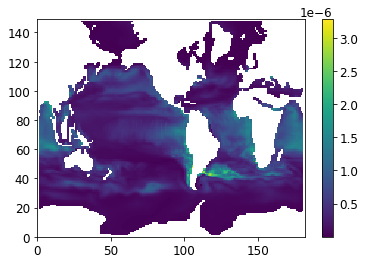

In [152]:
go = False
if go:
    tmax = 1
    stit = f'depth and magnitude of subsurface chl max in JJA (green) and DJF (grey) \n (mean and std. dev of 5th-95th percentile shown)'

    fact = 0.6
    seasons = ['DJF', 'MAM', 'JJA', 'SON']
    seascol = ['slategrey', 'chartreuse', 'forestgreen', 'gold']
    fig, axs = plt.subplots(1,2, figsize=(18*fact, 9*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    nbins = 50
    start = 0
    end = 250

    chlmin_threshold = (chlmax['chlmax'] > tmax)
    true_subsurface = (chlmax['max_below_first_measurement'] == 1.0)
    djf = ((chlmax['mon']>=12) | (chlmax['mon']<=2))
    mam = ((chlmax['mon']>=3) & (chlmax['mon']<=5))
    jja = ((chlmax['mon']>=6) & (chlmax['mon']<=8))
    son = ((chlmax['mon']>=9) & (chlmax['mon']<=11))



    axs[0].legend(loc = 'best', fontsize = 10)

    for r in range(0,len(regs)):
        regnum = regdict[regs[r]]['number']
        regcond = (chlmax['REG'] == regnum)
        jja_chld = (chlmax.loc[(jja & regcond & true_subsurface & true_max),['depth_chlmax']])
        jja_chl = (chlmax.loc[(jja & regcond & true_subsurface & true_max),['chlmax']])
        # axs[0].plot(jja_chl,-jja_chld, linestyle = '', marker = '.', color = 'green', alpha = 0.1)

        ### calc percentiles/ percentages
        tma = (np.percentile(jja_chl,95)); tmi = (np.percentile(jja_chl,5))
        jja_chl_t = jja_chl[(jja_chl>= tmi) & (jja_chl <= tma)]
        jja_chlm = (np.nanmean(jja_chl_t)); jja_chlst = (np.nanstd(jja_chl_t))
        tma = (np.percentile(jja_chld,95)); tmi = (np.percentile(jja_chld,5))
        jja_chld_t = jja_chld[(jja_chld>= tmi) & (jja_chld <= tma)]
        jja_chldm = (np.nanmean(jja_chld_t)); jja_chldst = (np.nanstd(jja_chld_t))

        axs[0].plot(jja_chlm,-jja_chldm, linestyle = '', marker = '*', \
                    markersize = 10, color = regdict[regs[r]]['colour'], alpha = 1, label = regs[r])
        st = jja_chlm - jja_chlst; en = jja_chlm + jja_chlst
        axs[0].hlines(y = -jja_chldm, xmin = st, xmax = en, \
                      color = regdict[regs[r]]['colour'], linewidth = 2)
        st = jja_chldm - jja_chldst; en = jja_chldm + jja_chldst
        #print(st); print(en)
        axs[0].vlines(x = jja_chlm, ymin = -st, ymax = -en, \
                      color = regdict[regs[r]]['colour'], linewidth = 2)

        djf_chld = (chlmax.loc[(djf & regcond & true_subsurface & true_max),['depth_chlmax']])
        djf_chl = (chlmax.loc[(djf & regcond & true_subsurface & true_max),['chlmax']])
        # axs[1].plot(djf_chl,-djf_chld, linestyle = '', marker = '.', color = 'green', alpha = 0.1)

        ### calc percentiles/ percentages
        tma = (np.percentile(djf_chl,95)); tmi = (np.percentile(djf_chl,5))
        djf_chl_t = djf_chl[(djf_chl>= tmi) & (djf_chl <= tma)]
        djf_chlm = (np.nanmean(djf_chl_t)); djf_chlst = (np.nanstd(djf_chl_t))
        tma = (np.percentile(djf_chld,95)); tmi = (np.percentile(djf_chld,5))
        djf_chld_t = djf_chld[(djf_chld>= tmi) & (djf_chld <= tma)]
        djf_chldm = (np.nanmean(djf_chld_t)); djf_chldst = (np.nanstd(djf_chld_t))

        axs[1].plot(djf_chlm,-djf_chldm, linestyle = '', marker = '*', \
                    markersize = 10, color = regdict[regs[r]]['colour'], alpha = 1, label = regs[r])
        st = djf_chlm - djf_chlst; en = djf_chlm + djf_chlst
        axs[1].hlines(y = -djf_chldm, xmin = st, xmax = en, \
                      color = regdict[regs[r]]['colour'], linewidth = 2)
        st = djf_chldm - djf_chldst; en = djf_chldm + djf_chldst
        #print(st); print(en)
        axs[1].vlines(x = djf_chlm, ymin = -st, ymax = -en, \
                      color = regdict[regs[r]]['colour'], linewidth = 2)

    axs[0].set_title('JJA')
    axs[1].set_title('DJF')

    axs[0].legend(ncol = 3, loc = 'lower right')
    for i in range(0,2):
        axs[i].set_xlim([0,5])
        axs[i].set_ylim([-250,0.3])
        axs[i].grid()
    # for i in range(0,len(regs)):
    #     axs[i+1].plot(5,-400,marker = "s", color = regdict[regs[i]]['colour'], amarkersize = 20)
    #     axs[i+1].text(5.8,-410,regs[i], color = 'k', fontsize = 16)

    plt.suptitle(stit, fontsize = 20, y = 1.02)
    plt.tight_layout()

accidental bauhaus plot thing for doing stacked barplots

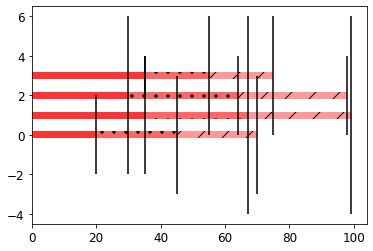

In [249]:
bauhaus = True
if bauhaus:
    diat_means = np.array([20, 35, 30, 35])
    flag_means = np.array([25, 32, 34, 20])
    cil_means = np.array([25, 32, 34, 20])
    men_std = [2, 3, 4, 1]
    women_std = [3, 5, 2, 3]
    width = 0.35       # the width of the bars: can also be len(x) sequence

    x = np.arange(4)

    fig, ax = plt.subplots()

    ax.barh(x, diat_means, width, yerr=men_std, label='diat',color = 'r', alpha = 0.8)
    ax.barh(x, flag_means, width, yerr=women_std, left=diat_means,
           label='flag', color = 'r', hatch='.', alpha = 0.6)
    ax.barh(x, cil_means, width, yerr=women_std, left=flag_means+diat_means, color = 'r', alpha = 0.4, 
           hatch = '/', label='cil')
